In [1]:
#!pip install yfinance

In [2]:
#!pip install plotly

In [3]:
#!pip install --upgrade nbformat

In [4]:
# load libraries
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import plotly.graph_objects as go
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from pathlib import Path
import os
#import warnings
#warnings.filterwarnings('ignore')
#pd.options.display.float_format = '${:,.2f}'.format

# Settings

In [5]:
symbol = 'BTC-USD'
#symbol = 'ETH-USD'

# Import

In [6]:
download_data = True

In [7]:
# Download data
if download_data:
    today = datetime.today().strftime('%Y-%m-%d')
    start_date = '2016-01-01'
    df_coin = yf.download(symbol, start_date, today)
    # We’ll reset the index, and we can have our Date as a column.
    df_coin.reset_index(inplace=True)
    df_coin.tail()
else:
    # get forecast & price data
    path = Path(os.getcwd())
    data_path = path.absolute()
    price_path = data_path / 'sample_data' / 'price_data.csv'
    df_price_data = pd.read_csv(price_path)

    df_coin = df_price_data[df_price_data['Coin'] == symbol][['Date','Open']]

    print(df_coin.head())

[*********************100%***********************]  1 of 1 completed


# Transform

In [8]:
df = df_coin[["Date", "Open"]]
new_names = {
    "Date": "ds", 
    "Open": "y",
}
df.rename(columns=new_names, inplace=True)

C:\Miniconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
df.tail()

,ds,y
2228,2022-02-06,41441.121094
2229,2022-02-07,42406.781250
2230,2022-02-08,43854.652344
2231,2022-02-09,44096.703125
2232,2022-02-10,44315.921875


In [10]:
# plot the open price
x = df["ds"]
y = df["y"]
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y))
# Set title
fig.update_layout(
    title_text="Time series plot of " + symbol + " Open Price",
)

# Model - explore

## Model settings

In [11]:
#? train data size
train_from = '2021-01-01'

In [12]:
validation_from = '2022-01-01' #? training data till this date, validation post this date

df_train = df[(df["ds"] < validation_from) & (df["ds"] > train_from)]
df_validate = df[df["ds"] >= validation_from]
print('Train shape: {}'.format(df_train.shape))
print('Validate shape: {}'.format(df_validate.shape))


Train shape: (364, 2)
Validate shape: (41, 2)


In [13]:
# sweep identified best params (for 10 days forecast)
# TO-DO validate if we use 10 days forecast in sweep?

# changepoint_prior_scale	seasonality_prior_scale	holidays_prior_scale	seasonality_mode	changepoint_range	rmse	mape	mdape	init_train_size
# 1000	0.01	0.01	multiplicative	0.99	5054.700263	0.075596901	0.052336558	2008
# 10	0.01	0.01	multiplicative	0.99	5150.84954	0.076853503	0.05393533	2008

growth='linear' # linear / logistic / flat


## Train

In [14]:

m = Prophet(
    growth=growth,
    changepoint_prior_scale=0.5, # recommended interval - log scale [0.001, 0.5]
    seasonality_prior_scale=0.01,
    holidays_prior_scale=0.01,
    seasonality_mode='additive',
    changepoint_range=0.99
)
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
future = m.make_future_dataframe(periods = 10)
#future['cap'] = 100000
future.tail()

,ds
369,2022-01-06
370,2022-01-07
371,2022-01-08
372,2022-01-09
373,2022-01-10


In [16]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
369,2022-01-06,47894.562747,44728.582004,51423.601681
370,2022-01-07,47746.081374,44173.385681,51273.308518
371,2022-01-08,47753.175947,44065.832471,51309.104847
372,2022-01-09,47722.947002,44047.836144,51448.730853
373,2022-01-10,47750.416907,44016.250113,51594.081285


In [17]:
# next_day = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
# forecast[forecast['ds'] == next_day]['yhat'].item()

## Validation

In [18]:
fig = plot_plotly(m, forecast)

fig.add_trace(
    go.Scatter(
        name= 'Validation',
        mode='markers',
        x=df_validate['ds'],
        y=df_validate['y'],
        marker=dict(
            # symbol = 'triangle-up',
            color='rgba(204, 20, 20, 0.5)',
            size=3,
            line=dict(
                color='Red',
                width=1
            )
        ),
        showlegend=True
    )
)

fig.update_layout(
    title_text="Actual Open price vs forecast",
)

fig.show()

In [19]:
plot_components_plotly(m, forecast)

# Model - inbuit validation

## Model settings

In [20]:
# sweep identified best params (for 10 days forecast)
# changepoint_prior_scale            1000.0
# seasonality_prior_scale              0.01
# holidays_prior_scale                 0.01
# seasonality_mode           multiplicative
# changepoint_range                    0.99
# rmse                          5054.700263
# mape                             0.075597
# mdape                            0.052337
# init_train_size                      2008

growth='linear' # linear / logistic / flat

df_train2 = df.copy()

In [21]:
#df_train2.shape
df_train2[df_train2['ds']<'2021-07-15'].shape

(2022, 2)

## Train

In [22]:
m2 = Prophet(
    growth=growth,
    changepoint_prior_scale=1000,
    seasonality_prior_scale=0.01,
    holidays_prior_scale=0.01,
    seasonality_mode='multiplicative',
    changepoint_range=0.99
)
m2.fit(df_train2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Validation
This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

Following code will:
- take 2000 days training data
- run forecast for 10 days
- shift by 5 days, re-train and run the forecast again

In [23]:
from fbprophet.diagnostics import cross_validation
run_heavy = False
if run_heavy == False:
    print('Skipped!')
else:
    df_cv = cross_validation(m2, initial='195 days', period='5 days', horizon = '10 days', parallel='processes')
    print(df_cv.head())


Skipped!


In [24]:
if run_heavy == False:
    print('Skipped!')
else:
    print(df_cv['cutoff'].unique())

Skipped!


In [25]:
from fbprophet.diagnostics import performance_metrics
if run_heavy == False:
    print('Skipped!')
else:
    df_p = performance_metrics(df_cv)
    print(df_p.head(15))

Skipped!


In [26]:
if run_heavy == True:
    print('MAPE for 10 days forecast: {:,.2f}%'.format(df_p['mape'].mean()*100))
    print('MAPE for  5 days forecast: {:,.2f}%'.format(df_p['mape'].head(5).mean()*100))

In [27]:
from fbprophet.plot import plot_cross_validation_metric
if run_heavy == False:
    print('Skipped!')
else:
    fig = plot_cross_validation_metric(df_cv, metric='mape')


Skipped!


# Model - custom validation
(probably not needed - better off with inbuild validation)

In [28]:
train_from = '2017-01-01'
validation_from = '2021-07-31' #? training data till this date, validation post this date

df_train = df[(df["ds"] < validation_from) & (df["ds"] > train_from)]
df_validate = df[df["ds"] >= validation_from]
print('Train shape: {}'.format(df_train.shape))
print('Validate shape: {}'.format(df_validate.shape))

Train shape: (1671, 2)
Validate shape: (195, 2)


#### get accuracy of fbprophet predictions

In [29]:
from sklearn import metrics as metrics 
import numpy as np

def get_metrics(df,day,forecast_lenght):
    # input:
    #     df: dataframe (expected columns: y, yhat)
    #     day: first day of the forecast
    # output:
    #     df_metrics: dataframe, metrics for this dataframe 
    #         ['ds','forecast_lenght','ME','MAE','RMSE','MAPE'])
    #           'ds' = day

    # Mean Forecast Error (or Forecast Bias)
    ME = np.mean(df['y'] - df['yhat'])
    #print('ME: {:,.2f}'.format(ME))

    # Mean Absolute Error
    MAE = metrics.mean_absolute_error(df['y'], df['yhat'])
    #print('MAE: {:,.2f}'.format(MAE))

    # Mean Squared Error
    MSE = metrics.mean_squared_error(df['y'], df['yhat'])
    #print('MSE: {:,.2f}'.format(MSE))

    # Root Mean Squared Error
    RMSE = np.sqrt(metrics.mean_squared_error(df['y'], df['yhat']))
    #print('RMSE: {:,.2f}'.format(RMSE))

    # Mean absolute percentage error
    MAPE = metrics.mean_absolute_percentage_error(df['y'], df['yhat'])
    #print('MAPE: {:,.2f}%'.format(MAPE*100))

    # Mean absolute percentage error - custom
    MAPE2 = np.mean(np.abs(df['y'] - df['yhat'])/df['y'])
    #print('MAPE2: {:,.2f}%'.format(MAPE2*100))

    return pd.DataFrame([[day, forecast_lenght, ME, MAE, RMSE, MAPE]],columns=['ds','forecast_lenght','ME','MAE','RMSE','MAPE'])

In [32]:
# loop over validation period and calculate accuracy metric
from train_predict import fbp_train_predict
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 
from tqdm import tqdm

df_metrics = pd.DataFrame([],columns=['ds','forecast_lenght','ME','MAE','RMSE','MAPE'])

run_heavy = False
if run_heavy == False:
    print('Skipped!')
else:
    for index, day in tqdm(df_validate.iterrows(), total=df_validate.shape[0]):
        # training data up to yesterday
        df_train = df[(df["ds"] < day.ds) & (df["ds"] > train_from)]

        # predict for 5 days: today + 4
        future = fbp_train_predict(df_train, coin=symbol, column_names=['Date','Open'], forecast_lenght=5, mode='forecast_only')

        # compare real vs forecasted
        df_accuracy = df_validate[df_validate['ds'].isin(future['ds'])]
        df_accuracy.reset_index(drop=True,inplace=True)
        df_accuracy['yhat'] = future['yhat']

        # get metrics for today
        df_append_line = get_metrics(df_accuracy, day=day.ds, forecast_lenght=5)
        df_metrics= df_metrics.append(df_append_line,ignore_index=True)

Skipped!


In [33]:
# save data
if run_heavy == False:
    print('Skipped!')
else:
    df_metrics.to_csv('prophet_metrics.csv', index=False, mode='a', header=True) # ? first time add header

Skipped!


In [34]:
# plot the open price
if run_heavy == False:
    print('Skipped!')
else:
    x = df_metrics["ds"]
    y = df_metrics["MAPE"]
    mean = df_metrics['MAPE'].mean()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y))
    fig.add_hline(y=mean, line_dash="dot",
                annotation_text="mean = {:3.1f}%".format(mean*100), 
                annotation_position="bottom right")
    # Set title
    fig.update_layout(
        title_text="fbprophet MAPE",
    )

Skipped!


In [35]:
if run_heavy == False:
    print('Skipped!')
else:
    df_metrics.tail()

Skipped!


__Parameters that can be tunned:__
- changepoint_prior_scale: a range of [0.001, 0.5] would likely be about right.
- seasonality_prior_scale: [0.01, 10]
- holidays_prior_scale: [0.01, 10]
- seasonality_mode: Options are ['additive', 'multiplicative']

__Possible to tune:__
- changepoint_range: [0.8, 0.95]
- train set size - too much data might lead to overfit

## Sweep validation

In [36]:
# get results generated in AML
path = Path(os.getcwd())
data_path = path.absolute()
param_path = data_path / 'metrics' / 'fbprophet_sweep_eth.csv'
tuning_results_all = pd.read_csv(param_path)

tuning_results_all.sort_values('mape').head(20)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,rmse,mape,mdape,init_train_size
184,0.5,0.10,0.01,additive,0.99,409.895088,0.099035,0.082653,1330
194,0.5,0.10,10.00,additive,0.99,409.895088,0.099035,0.082653,1330
234,0.5,10.00,10.00,additive,0.99,416.792373,0.099855,0.080074,1330
224,0.5,10.00,0.01,additive,0.99,416.792373,0.099855,0.080074,1330
214,0.5,1.00,10.00,additive,0.99,420.494919,0.100964,0.082036,1330
204,0.5,1.00,0.01,additive,0.99,420.494919,0.100964,0.082036,1330
164,0.5,0.01,0.01,additive,0.99,431.801080,0.103008,0.079700,1330
174,0.5,0.01,10.00,additive,0.99,431.801080,0.103008,0.079700,1330
294,10.0,1.00,10.00,additive,0.99,454.658538,0.105517,0.082960,1330
284,10.0,1.00,0.01,additive,0.99,454.658538,0.105517,0.082960,1330


In [37]:
mape_best_params = tuning_results_all.iloc[tuning_results_all['mape'].argmin()]
mdape_best_params = tuning_results_all.iloc[tuning_results_all['mdape'].argmin()]
print('MAPE:\n{}\n'.format(mape_best_params))
print('MDAPE:\n{}'.format(mdape_best_params))

MAPE:
changepoint_prior_scale           0.5
seasonality_prior_scale           0.1
holidays_prior_scale             0.01
seasonality_mode             additive
changepoint_range                0.99
rmse                       409.895088
mape                         0.099035
mdape                        0.082653
init_train_size                  1330
Name: 184, dtype: object

MDAPE:
changepoint_prior_scale            1000.0
seasonality_prior_scale              0.01
holidays_prior_scale                 0.01
seasonality_mode           multiplicative
changepoint_range                     0.8
rmse                           458.723797
mape                               0.1122
mdape                            0.068968
init_train_size                      1330
Name: 405, dtype: object


In [38]:
tuning_results_all.corr()

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,rmse,mape,mdape,init_train_size
changepoint_prior_scale,1.000000e+00,4.849694e-17,-3.936525e-17,-4.768981e-16,-3.814964e-02,-5.349406e-02,-1.533655e-01,-3.419592e-16
seasonality_prior_scale,4.849694e-17,1.000000e+00,-8.138063e-18,-3.830868e-16,8.594498e-02,1.287679e-01,7.795498e-02,-3.231393e-16
holidays_prior_scale,-3.936525e-17,-8.138063e-18,1.000000e+00,-1.015516e-16,5.016709e-16,-3.754893e-16,-2.253973e-16,5.551668e-16
changepoint_range,-4.768981e-16,-3.830868e-16,-1.015516e-16,1.000000e+00,3.334882e-02,-1.531281e-02,-1.876445e-02,8.655618e-15
rmse,-3.814964e-02,8.594498e-02,5.016709e-16,3.334882e-02,1.000000e+00,-4.371514e-01,-3.377268e-01,8.852551e-01
mape,-5.349406e-02,1.287679e-01,-3.754893e-16,-1.531281e-02,-4.371514e-01,1.000000e+00,8.789775e-01,-6.638000e-01
mdape,-1.533655e-01,7.795498e-02,-2.253973e-16,-1.876445e-02,-3.377268e-01,8.789775e-01,1.000000e+00,-5.506087e-01
init_train_size,-3.419592e-16,-3.231393e-16,5.551668e-16,8.655618e-15,8.852551e-01,-6.638000e-01,-5.506087e-01,1.000000e+00


In [39]:
from pylab import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = 7,7 
import seaborn as sns
#sns.set(color_codes=True, font_scale=1.2)

from heatmap import heatmap, corrplot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

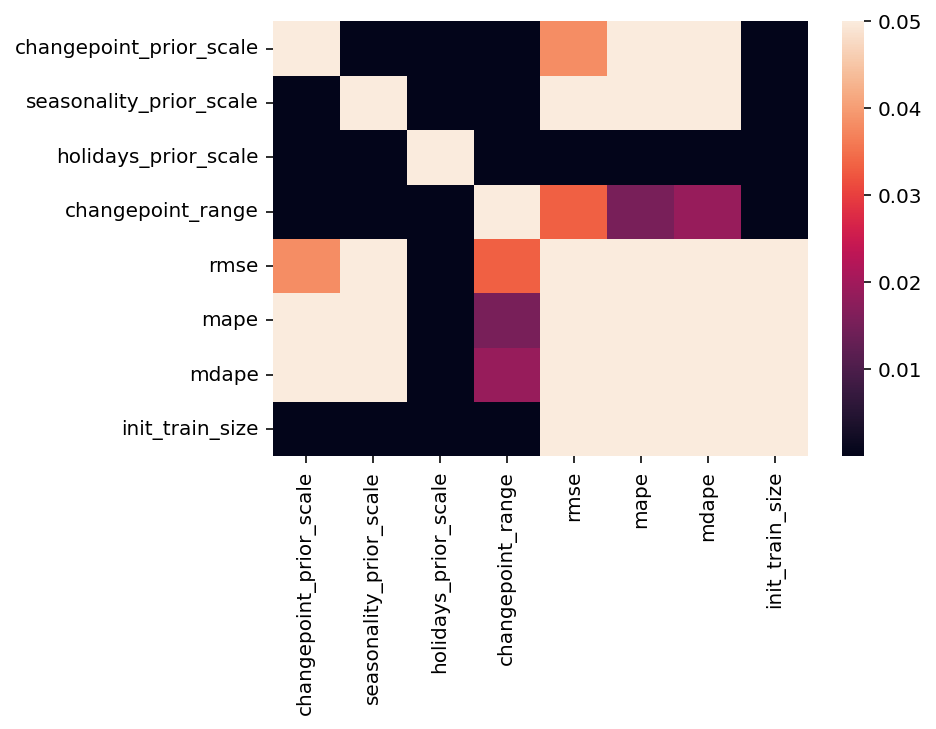

In [40]:
sns.color_palette("icefire", as_cmap=True)
#sns.color_palette("vlag", as_cmap=True)
#sns.color_palette("YlOrBr", as_cmap=True)
#ax = sns.heatmap(df_corr_matrix, vmax=1.0, vmin=-1.0)
ax = sns.heatmap(np.abs(tuning_results_all.corr()), vmax=0.05, vmin=0.00001)

In [41]:
# test precision accross different param setting
train_size_influence = tuning_results_all[
    (tuning_results_all['changepoint_prior_scale'] == 0.5)&
#	(tuning_results_all['seasonality_prior_scale'] == 0.01) &
    (tuning_results_all['holidays_prior_scale'] == 0.01) &
    (tuning_results_all['seasonality_mode'] == 'additive') & # multiplicative / additive
    (tuning_results_all['init_train_size'] == 1330) &
    (tuning_results_all['changepoint_range'] == 0.99)
    ]

train_size_influence

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,rmse,mape,mdape,init_train_size
164,0.5,0.01,0.01,additive,0.99,431.801080,0.103008,0.079700,1330
184,0.5,0.10,0.01,additive,0.99,409.895088,0.099035,0.082653,1330
204,0.5,1.00,0.01,additive,0.99,420.494919,0.100964,0.082036,1330
224,0.5,10.00,0.01,additive,0.99,416.792373,0.099855,0.080074,1330


# Parameter sweep
Sweep code available in folder aml_jobs

# Triple barier method

### TB after forecast

In [42]:
from process_raw import form_label

# create labels
tbl = form_label(df_coin, ['Date','Open'], threshold_type='ratio', threshold=0.05, T=5)

In [43]:
df_tbl = df_coin.copy()
df_tbl['label'] = tbl
df_coin.shape

(2233, 7)

In [44]:
df_tbl.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,label
2223,2022-02-01,38481.765625,39115.132812,38113.664062,38743.273438,38743.273438,20288500328,1.0
2224,2022-02-02,38743.714844,38834.617188,36832.730469,36952.984375,36952.984375,19155189416,1.0
2225,2022-02-03,36944.804688,37154.601562,36375.539062,37154.601562,37154.601562,18591534769,1.0
2226,2022-02-04,37149.265625,41527.785156,37093.628906,41500.875000,41500.875000,29412210792,1.0
2227,2022-02-05,41501.480469,41847.164062,41038.097656,41441.164062,41441.164062,19652846215,1.0
2228,2022-02-06,41441.121094,42500.785156,41244.906250,42412.433594,42412.433594,16142097334,-2.0
2229,2022-02-07,42406.781250,44401.863281,41748.156250,43840.285156,43840.285156,28641855926,-2.0
2230,2022-02-08,43854.652344,45293.867188,42807.835938,44118.445312,44118.445312,33079398868,-2.0
2231,2022-02-09,44096.703125,44727.800781,43232.968750,44338.796875,44338.796875,23245887300,-2.0
2232,2022-02-10,44315.921875,45661.171875,43402.808594,44709.179688,44709.179688,30567475200,-2.0


In [45]:
print('  1: days where price rises:    {}'.format(df_tbl[df_tbl['label'] == 1]['label'].count()))
print('  0: days where price stays:    {}'.format(df_tbl[df_tbl['label'] == 0]['label'].count()))
print('- 1: days where price declines: {}'.format(df_tbl[df_tbl['label'] == -1]['label'].count()))
print('- 2: last 5 days:               {}'.format(df_tbl[df_tbl['label'] == -2]['label'].count()))

  1: days where price rises:    787
  0: days where price stays:    882
- 1: days where price declines: 559
- 2: last 5 days:               5


In [46]:
# actuals - labels
x = df["ds"]
y = df["y"]
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, name='Open price'))
# Set title
fig.update_layout(
    title_text="Actual Open price - Labels",
)

fig.add_trace(
    go.Scatter(
        name= 'Down',
        mode='markers',
        x=df_tbl[df_tbl['label'] == -1]['Date'],
        y=df_tbl[df_tbl['label'] == -1]['Open'],
        marker=dict(
            # symbol = 'triangle-up',
            color='rgba(204, 20, 20, 0.5)',
            size=3,
            line=dict(
                color='Red',
                width=1
            )
        ),
        showlegend=True
    )
)

fig.add_trace(
    go.Scatter(
        name= 'Up',
        mode='markers',
        x=df_tbl[df_tbl['label'] == 1]['Date'],
        y=df_tbl[df_tbl['label'] == 1]['Open'],
        marker=dict(
            # symbol = 'triangle-up',
            color='rgba(20, 200, 20, 0.5)',
            size=3,
            line=dict(
                color='Green',
                width=1
            )
        ),
        showlegend=True
    )
)

fig.show()

### Validate TB accuracy
- for the best fbp model
- adjusting TB params? TBC

In [47]:
threshold=0.03
T=3

In [48]:
tbl = form_label(df_coin, ['Date','Open'], threshold_type='ratio', threshold=threshold, T=T)
df_tbl = df_coin.copy()
df_tbl['label'] = tbl

In [49]:
train_from = '2017-01-01'
validation_from = '2021-07-31' #? training data till this date, validation post this date

df_first_train = df_tbl[(df_tbl["Date"] <= validation_from) & (df_tbl["Date"] > train_from)]
df_validate = pd.DataFrame(df_tbl[df_tbl["Date"] >= validation_from])
print('First train shape: {}'.format(df_first_train.shape))
print('Validate shape: {}'.format(df_validate.shape))

First train shape: (1672, 8)
Validate shape: (195, 8)


In [50]:
# loop over validation period and calculate accuracy metric
from train_predict import fbp_train_predict
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 
from tqdm import tqdm
from process_raw import form_label
from sklearn import metrics as metrics

df_metrics_x = pd.DataFrame([],columns=['Date','label','label_hat'])

run_heavy = True
if run_heavy == False:
    print('Skipped!')
else:
    for index, day in tqdm(df_validate.iterrows(), total=df_validate.shape[0]):
        # training data up to yesterday
        df_train = df_tbl[(df_tbl["Date"] <= day.Date) & (df_tbl["Date"] > train_from)]
        # print('Train for {}:'.format(day.Date))
        
        # predict for x days: today + x
        future = fbp_train_predict(df_train, coin=symbol, column_names=['Date','Open'], forecast_lenght=T, mode='forecast_only')

        # compare real vs forecasted
        df_accuracy_day = df_validate[df_validate['Date'].isin(future['ds'])]
        df_accuracy_day.reset_index(drop=True,inplace=True)
        df_accuracy_day['yhat'] = future['yhat']
        # add today
        today_line = df_validate[df_validate['Date'] == day.Date]
        today_line['yhat'] = today_line['Open']

        df_accuracy_day = df_accuracy_day.append(
            today_line,
            ignore_index=True
        )
 
        df_accuracy_day.sort_values('Date',ascending=True,inplace=True)
        
        # create labels for forecasted
        tbl_hat = form_label(df_accuracy_day, ['Date','yhat'], threshold_type='ratio', threshold=threshold, T=T)
        df_accuracy_day['label_hat'] = tbl_hat
        df_accuracy_day = df_accuracy_day[df_accuracy_day['Date'] == day.Date]
        df_accuracy_day = df_accuracy_day[['Date','label','label_hat']]

        # append today
        # ['ds','label','label_hat']
        df_metrics_x = df_metrics_x.append(df_accuracy_day, ignore_index=True)
        
        # #test
        # print(df_metrics_5)
        # datetime_object = datetime.strptime('2021-07-31', '%Y-%m-%d')
        # if day.Date > datetime_object:
        #     break
        
df_metrics_x['Coin'] = symbol

100%|██████████| 195/195 [1:03:32<00:00, 19.55s/it]


In [51]:
filename = 'fbp_accuracy_' + str(symbol) + '_T' + str(T) +'_t' + str(int(threshold*100)) + '.csv'
filename

'fbp_accuracy_BTC-USD_T3_t3.csv'

In [52]:
df_metrics_x = df_metrics_x[df_metrics_x['label'] != -2]
df_metrics_x.to_csv(filename, header=True)

In [53]:
df_metrics_x.tail(10)

,Date,label,label_hat,Coin
182,2022-01-29,0.0,-1.0,BTC-USD
183,2022-01-30,0.0,-1.0,BTC-USD
184,2022-01-31,0.0,0.0,BTC-USD
185,2022-02-01,-1.0,-1.0,BTC-USD
186,2022-02-02,-1.0,0.0,BTC-USD
187,2022-02-03,1.0,0.0,BTC-USD
188,2022-02-04,1.0,0.0,BTC-USD
189,2022-02-05,1.0,-1.0,BTC-USD
190,2022-02-06,1.0,-1.0,BTC-USD
191,2022-02-07,1.0,-1.0,BTC-USD


In [55]:
accuracy = metrics.accuracy_score(df_metrics_x['label'], df_metrics_x['label_hat'])

print('{}: fbp TB (T{}-t{}%) classification accuracy over {} days forecast: {:,.2f}%'.format(symbol,T,int(threshold*100),T,accuracy*100))

# Print the confusion matrix
print('Confusion matrix: ')
print(metrics.confusion_matrix(df_metrics_x['label'], df_metrics_x['label_hat']))
# Print the precision and recall, among other metrics
print(metrics.classification_report(df_metrics_x['label'], df_metrics_x['label_hat'], digits=3))



BTC-USD: fbp TB(T3-t3%) classification accuracy over 3 days forecast: 37.50%
Confusion matrix: 
[[30 28 13]
 [22 16 11]
 [15 31 26]]
              precision    recall  f1-score   support

        -1.0      0.448     0.423     0.435        71
         0.0      0.213     0.327     0.258        49
         1.0      0.520     0.361     0.426        72

    accuracy                          0.375       192
   macro avg      0.394     0.370     0.373       192
weighted avg      0.415     0.375     0.386       192



### result
- BTC-USD: fbp TB (T5-t5%) classification accuracy over 5 days forecast: 41.05%
- BTC-USD: fbp TB (T3-t3%) classification accuracy over 3 days forecast: 37.50%